In [11]:
import pandas as pd
import numpy as np
import json
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load data

In [12]:
df = pd.read_csv('/gh/data/personal-data-requests/uber/Uber Data/Rider/trips_data.csv')
df.loc[[3]]

,City,Product Type,Trip or Order Status,Request Time,Begin Trip Time,Begin Trip Lat,Begin Trip Lng,Begin Trip Address,Dropoff Time,Dropoff Lat,Dropoff Lng,Dropoff Address,Distance (miles),Fare Amount,Fare Currency
3,San Francisco,UberX,COMPLETED,2019-06-22 16:21:40 +0000 UTC,2019-06-22 16:25:46 +0000 UTC,37.76372,-122.4793,"1279 21st Ave, San Francisco, CA 94122, US",2019-06-22 16:32:09 +0000 UTC,37.77485,-122.51116,"704 Great Hwy, San Francisco, CA 94121, USA",2.36,9.61,USD


In [13]:
df['Distance (miles)'].sum()

603.53

In [14]:
df['Fare Amount'].sum()

1658.4600000000003

# 2. Fare per mile/minute

In [15]:
def compute_usd_fare(row):
    if row['Fare Currency'] == 'USD':
        return row['Fare Amount']
    elif row['Fare Currency'] == 'TWD':
        return row['Fare Amount'] * .032
    else:
        raise ValueError('unknown currency')

# df2 = df[df['Product Type'].isin(['UberX', 'uberX', 'uberXL', 'Express Pool: MATCHED'])].reset_index(drop=True)
df2 = df[df['Product Type'].isin(['UberX', 'uberX'])].reset_index(drop=True)
df2['fare_usd'] = df2.apply(compute_usd_fare, axis=1)
df2 = df2[df2['fare_usd'] > 0]
df2['Dropoff Time'] = [x[:-10] for x in df2['Dropoff Time']]
df2['Begin Trip Time'] = [x[:-10] for x in df2['Begin Trip Time']]
df2['n_min'] = pd.to_datetime(df2['Dropoff Time']) - pd.to_datetime(df2['Begin Trip Time'])
df2['n_min'] = df2['n_min'].dt.seconds / 60
df2['usd_per_mile'] = df2['fare_usd'] / df2['Distance (miles)']
df2['usd_per_min'] = df2['fare_usd'] / df2['n_min']
df2['year'] = pd.to_datetime(df2['Dropoff Time']).dt.year

# 3. Fare per minute and mile by city

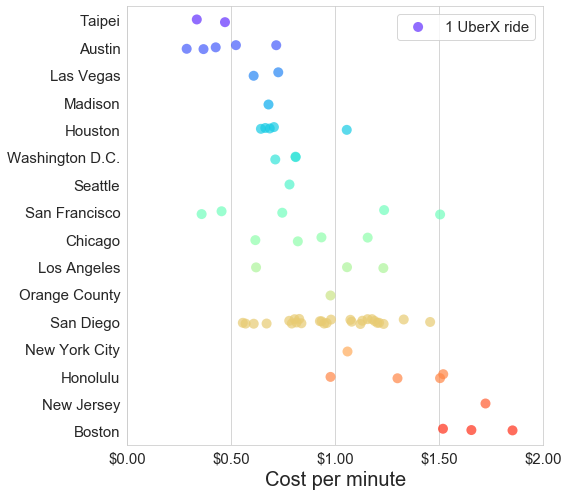

In [16]:
plt.figure(figsize=(8,7))
sns.stripplot(x='usd_per_min', y='City', data=df2, color='k', alpha=.7, size=10,
              palette=sns.color_palette('rainbow', n_colors=df2['City'].nunique()),
              order=df2.groupby('City')['usd_per_min'].mean().sort_values().index)
plt.ylabel('')
plt.xlabel('Cost per minute')
plt.legend(['1 UberX ride'], fontsize=15)
plt.xlim((0,2))
plt.xticks(np.arange(0,2.5,.5))

import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.2f')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/uber_cost_per_minute_by_city.png')

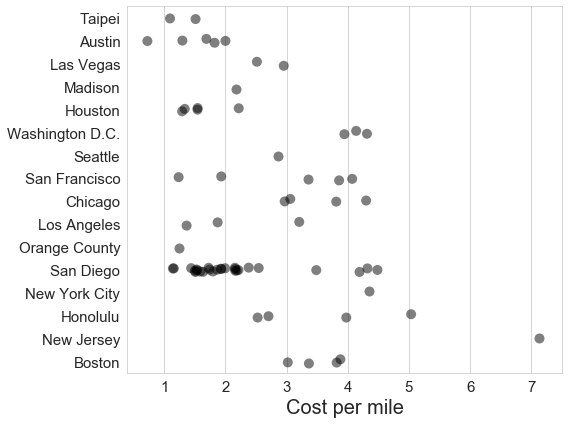

In [17]:
plt.figure(figsize=(8,6))
sns.stripplot(x='usd_per_mile', y='City', data=df2, color='k', alpha=.5, size=10,
            order=df2.groupby('City')['usd_per_min'].mean().sort_values().index)
plt.ylabel('')
plt.xlabel('Cost per mile')
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/uber_cost_per_mile_by_city.png')

# 4. Cost over 2014-2019

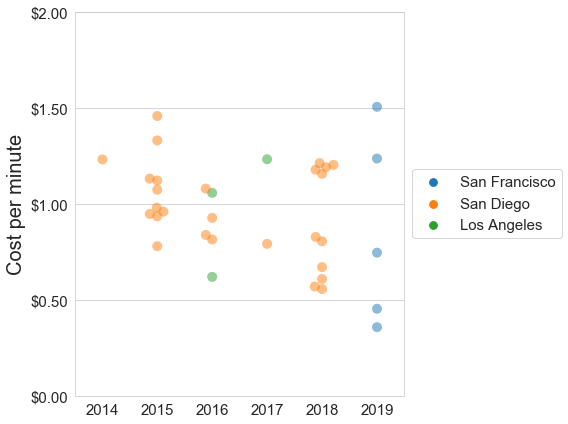

In [18]:
df_plt = df2[df2['City'].isin(['San Diego', 'San Francisco', 'Los Angeles'])]
plt.figure(figsize=(8,6))
sns.swarmplot(x='year', y='usd_per_min', hue='City',
              data=df_plt, alpha=.5, size=10)
plt.xlabel('')
plt.ylabel('Cost per minute')
plt.yticks(np.arange(0,2.5,.5))

# dollar ticks
formatter = ticker.FormatStrFormatter('$%1.2f')
plt.gca().yaxis.set_major_formatter(formatter)

# Format legend
leg = plt.legend(fontsize=15, loc='center left', bbox_to_anchor=[1, .5])
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/uber_cost_per_minute_by_year_California.png')

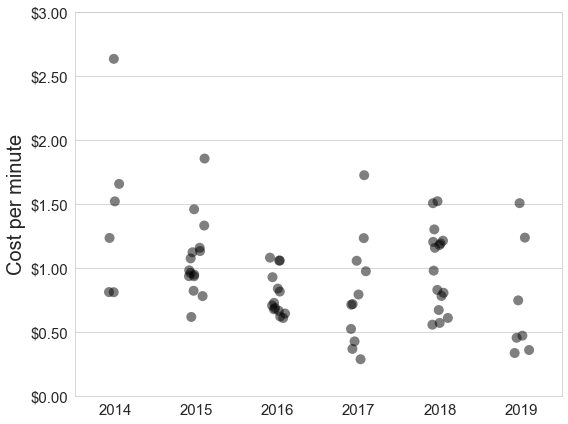

In [26]:
plt.figure(figsize=(8,6))
sns.stripplot(x='year', y='usd_per_min', 
              data=df2, color='k', alpha=.5, size=10)
plt.xlabel('')
plt.ylabel('Cost per minute')
plt.yticks(np.arange(0,3.5,.5))

# dollar ticks
formatter = ticker.FormatStrFormatter('$%1.2f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig('/gh/srcole.github.io/assets/personaldata/uber_cost_per_minute_by_year.png')

# 5. Cumulative spent on Uber

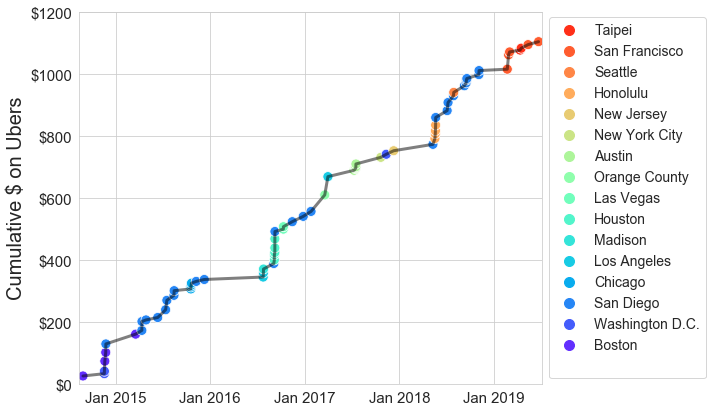

In [23]:
df_plt = df2[['City', 'Begin Trip Time', 'fare_usd']].rename(columns={'Begin Trip Time': 'ts'}).sort_values('ts').reset_index(drop=True)
df_plt['ts'] = pd.to_datetime(df_plt['ts'])
df_plt['cum_fare'] = df_plt['fare_usd'].cumsum()

plt.figure(figsize=(10,6))
sns.lineplot(x='ts', y='cum_fare', data=df_plt, color='k', linewidth=3, alpha=.5)
sns.scatterplot(x='ts', y='cum_fare', data=df_plt, hue='City',
                palette=sns.color_palette('rainbow', n_colors=df_plt['City'].nunique()),
                hue_order=df_plt.groupby('City')['ts'].min().sort_values().index)
plt.ylabel('Cumulative $ on Ubers')
plt.xlim(df_plt['ts'].min() - datetime.timedelta(days=15), df_plt['ts'].max() + datetime.timedelta(days=15))
plt.xticks([datetime.datetime(x, 1, 1) for x in np.arange(2015,2020)], ['Jan {}'.format(x) for x in np.arange(2015,2020)])
plt.ylim((0, 1200))
plt.xlabel('')

# dollar ticks
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

# plt.gca().legend(title='Line', loc='upper left')

handles, labels = plt.gca().get_legend_handles_labels()
leg = plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1,.5), fontsize=14)
leg.texts[-1].set_text(None)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/uber_cumulative_spent.png')